In [1]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import numpy as np
import pandas as pd
import math 
import os, sys
from scipy.stats import multivariate_normal

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)
from enum import Enum

CURRENT_DIR = os.path.dirname(os.path.abspath("rare_pattern_detect"))
sys.path.append(os.path.dirname(CURRENT_DIR))

from rare_pattern_detect.patterns import PatternSpace, PatternSpaceType, MIN_AREA
from rare_pattern_detect.minlp_based import minlp_has_rare_pattern
from rare_pattern_detect.rare_pattern_detect import RarePatternDetect
from rare_pattern_detect.pattern_space_utils import draw_largest_bounding_area, draw2dpattern

# Notes: 
    - FIXME: Problem f_hat is zero eventhough point is inside the pattern 
    - ERROR: Unable to clone Pyomo component attribute. Component
        'interval_constraint_index' contains an uncopyable field '_init_dimen'
        (<class 'pyomo.core.base.initializer.ConstantInitializer'>).  Setting
        field to `None` on new object
    - Using only two features we get different values for f_hat. However when using more (3 features) most of the f_hat values are equal to zero
# TODO:
    - Run the minlp solver on the cardio dataset and evaluate the performance using metrics
        - Calculate the false positive and false negative rate for the AUROC curve
        - Create AUROC curve using the variable (U_min, delta, epsilon, range for tau (should be relative to the value of f_hat)) -> single curve 
        - Repeat this for different U_min and plot all the auroc curves in one plot
    - Compare performance to SVM, RF using the metrics for supervised learning
    - Create a single 3D test (cube)


In [2]:
# MIN_AREA = 0.3 # 0.3

In [3]:
# # cmap = plt.get_cmap('viridis')

# # training_set =  np.array(
# #     [[0.0, 0.0], [2.0, 0.0], [0.0, 2.0], [2.0, 2.0]]
# # )
training_set = multivariate_normal.rvs(size=(100,2))
# # point_to_be_classified = np.array([[0.25,0.25]])
testing_set = multivariate_normal.rvs(size=(10,2))

# # os.listdir('../ADbench-main/datasets/Classical')
# # b = np.load('../ADbench-main/datasets/Classical/6_cardio.npz')
# # b.keys()
# # print(b.files)

# with np.load('../ADBench-main/datasets/Classical/6_cardio.npz') as data:
#     X = data['X']
#     y = data['y']
#     idx = np.random.permutation(len(X))
#     X,y = X[idx], y[idx]

# #  number of points is 1831
# print("number of datapoints is: ",len(y))

# # number of feature per data point is 21
# print("number of feature per data point is: ", len(X[0]))


# TRAINING_LIMIT = 200
# TESTING_LIMIT = 10
# FEATURES = 2

# X = X[:TRAINING_LIMIT+TESTING_LIMIT,:FEATURES]
# y = y[:TRAINING_LIMIT+TESTING_LIMIT]

# training_set = X[:TRAINING_LIMIT]
# training_labels = y[:TRAINING_LIMIT]

# testing_set = X[TRAINING_LIMIT:-1]
# testing_labels = y[TRAINING_LIMIT:-1]

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


min_area:  63.0
N=100 , d=2, vc=4
------- itr: 0 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.51


    functionality.  (deprecated in 6.4.2) (called from
    /Users/p392827/Desktop/PDG/porsche-research/pac-learning/pac-
    venv/lib/python3.9/site-
    packages/pyomo/contrib/mindtpy/initialization.py:154)


         1              MILP          0.066959            inf       0.066959      nan%      1.03
*        1         Fixed NLP          0.479231       0.479231       0.066959    86.03%      1.30
         2              MILP         0.0693085       0.479231      0.0693085    85.54%      1.49
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP          0.074499       0.479231       0.074499    84.45%      2.16
*        3         Fixed NLP          0.310682       0.310682       0.074499    76.02%      2.43
         4              MILP          0.127451       0.310682       0.127451    58.98%      2.61
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.261877       0.310682       0.261877    15.71%      3.70
         5         Fixed NLP          0.978907       0.310682       0.261877    15.71%      3.95
         6              MILP          0.310682       0.310682       0.310682    -0.00%    

evaluating: [ 0.39641119 -1.67061935] -> f_hat:0.31068243772489224 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  3.2187207211419357


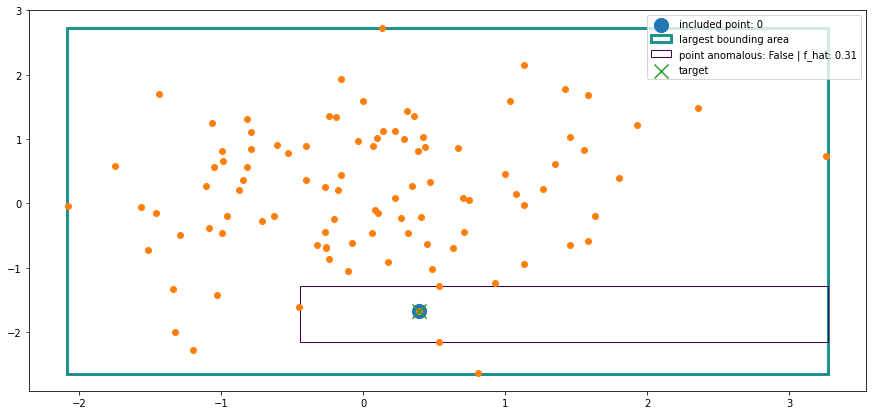

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 1 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.48
         1              MILP         0.0690865            inf      0.0690865      nan%      0.67
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0692421            inf      0.0692421      nan%      1.73
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0875766            inf      0.0875766      nan%      2.69
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP         0.0956409            inf      0.0956409      nan%      4.09
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP           4.42484            inf        4.42484      nan%      7.75
NLP subpro

evaluating: [-0.17390929  0.20351853] -> f_hat:4.93050293118479 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.0140953305951101


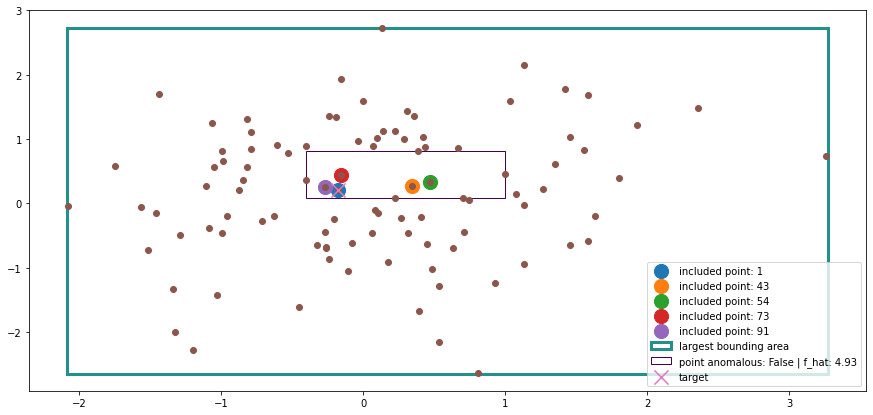

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



------- itr: 2 -------
cutoff (min_area):  63.0


         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.44
         1              MILP         0.0687645            inf      0.0687645      nan%      0.66
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0690554            inf      0.0690554      nan%      1.42
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0803564            inf      0.0803564      nan%      3.33
*        3         Fixed NLP           0.97353        0.97353      0.0803564    91.75%      3.61
         4              MILP         0.0951936        0.97353      0.0951936    90.22%      4.47
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.151817        0.97353       0.151817    84.41%      5.91
*        5         Fixed NLP          0.858898       0.858898       0.151817    82.32%      6.19
         6             

evaluating: [ 0.48670553 -1.02251988] -> f_hat:0.8197319094671532 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  4.879644129749813


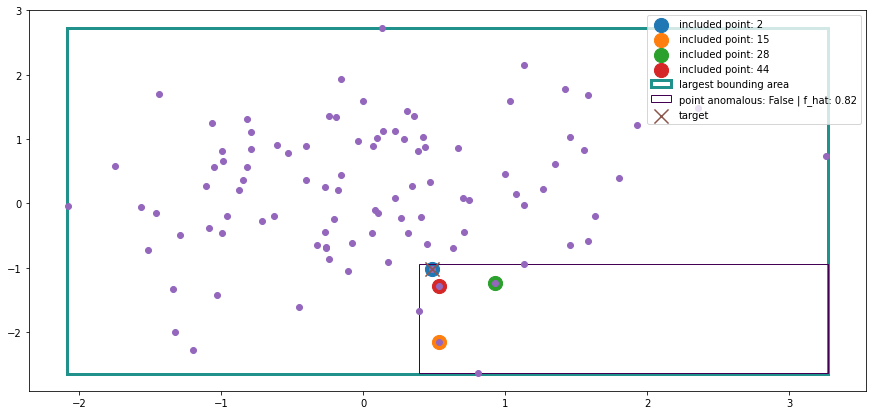

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 3 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.54
         1              MILP         0.0684661            inf      0.0684661      nan%      0.75
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0685757            inf      0.0685757      nan%      2.17
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0936576            inf      0.0936576      nan%      4.59
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP           1.07928            inf        1.07928      nan%      9.02
*        4         Fixed NLP           1.38694        1.38694        1.07928    22.18%      9.30
         5              MILP           1.19536        1.38694        1.19536 

evaluating: [-0.52760125  0.77971095] -> f_hat:1.3869401691380048 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.442023271445817


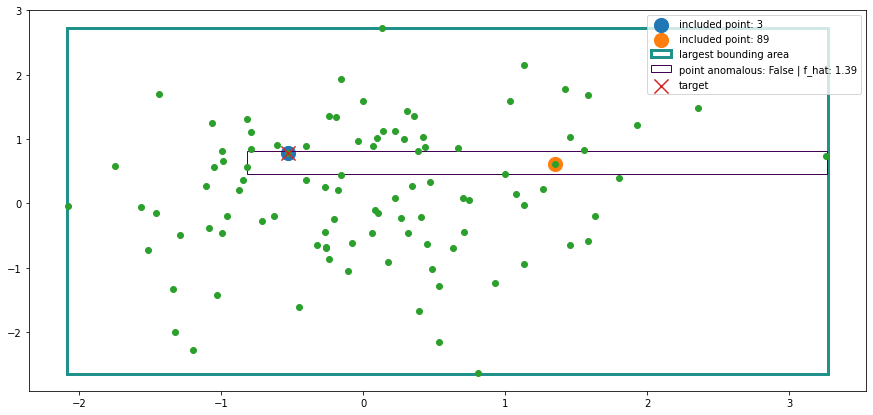

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



------- itr: 4 -------
cutoff (min_area):  63.0
ERROR: Unable to clone Pyomo component attribute. Component
    'pattern_constraint_index' contains an uncopyable field '_init_dimen'
    (<class 'pyomo.core.base.initializer.ConstantInitializer'>).  Setting
    field to `None` on new object


         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.47
         1              MILP         0.0692448            inf      0.0692448      nan%      0.69
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0692812            inf      0.0692812      nan%      1.78
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0927502            inf      0.0927502      nan%      2.74
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP         0.0944414            inf      0.0944414      nan%      3.66
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.137726            inf       0.137726      nan%      5.94
*        5         Fixed NLP           2.94802        2.94802       0.137726    95.33%      6.23
         6              MILP          0.187647       

evaluating: [-0.791378    0.84709352] -> f_hat:1.6110234128286065 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  2.4828937730810945


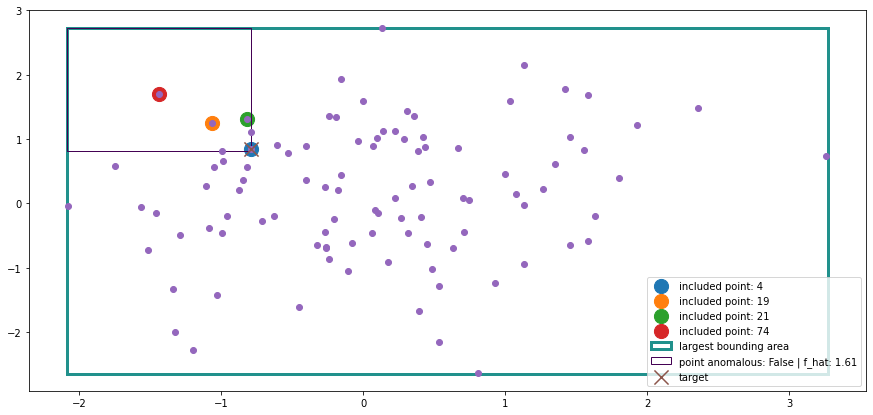

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



------- itr: 5 -------
cutoff (min_area):  63.0


         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.43
         1              MILP         0.0693536            inf      0.0693536      nan%      0.62
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0693606            inf      0.0693606      nan%      1.46
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0934995            inf      0.0934995      nan%      2.48
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP          0.129647            inf       0.129647      nan%      3.52
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.185709            inf       0.185709      nan%      7.35
NLP subproblem was locally infeasible.
Solving feasibility problem
         6              MILP          0.250817            inf       0.250817      n

evaluating: [0.06933391 0.89947399] -> f_hat:3.1980571949314105 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.8761390538947766


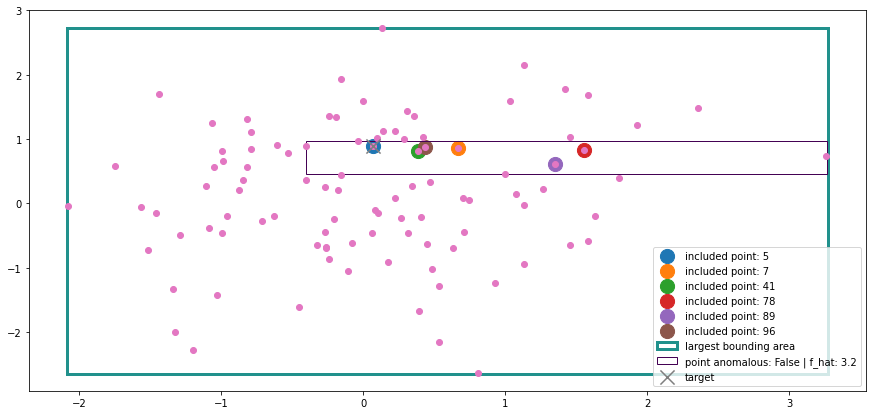

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



------- itr: 6 -------
cutoff (min_area):  63.0


         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.57
         1              MILP         0.0686763            inf      0.0686763      nan%      0.77
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0686838            inf      0.0686838      nan%      1.48
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0757649            inf      0.0757649      nan%      2.28
*        3         Fixed NLP          0.736456       0.736456      0.0757649    89.71%      2.56
         4              MILP         0.0908031       0.736456      0.0908031    87.67%      2.87
         4         Fixed NLP          0.954422       0.736456      0.0908031    87.67%      3.11
         5              MILP          0.736456       0.736456       0.736456    -0.00%      3.40
MindtPy exiting on bound convergence. Absolute gap: -4.095999639464054e-08 <= absolute tol

evaluating: [-1.28956479 -0.49462182] -> f_hat:0.7364556994728357 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.3578549269369669


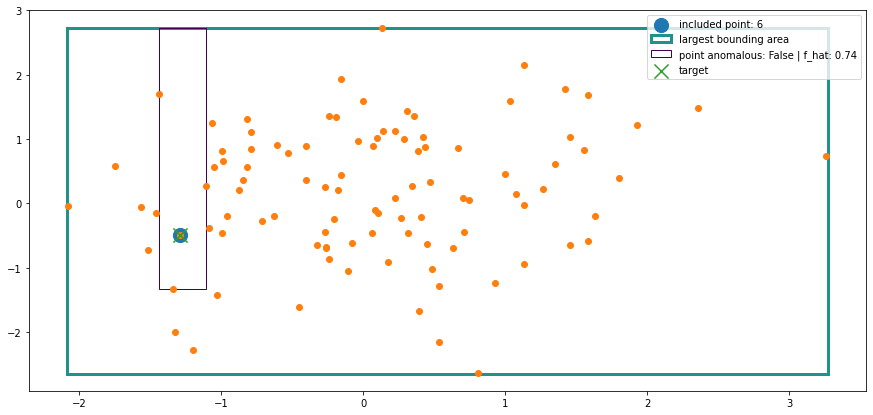

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



------- itr: 7 -------
cutoff (min_area):  63.0


         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.42
         1              MILP          0.068985            inf       0.068985      nan%      0.60
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP          0.069254            inf       0.069254      nan%      1.42
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0804935            inf      0.0804935      nan%      2.22
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP         0.0836559            inf      0.0836559      nan%      3.21
*        4         Fixed NLP          0.711725       0.711725      0.0836559    88.25%      3.51
         5              MILP         0.0844529       0.711725      0.0844529    88.13%      3.89
NLP subproblem was locally infeasible.
Solving feasibility problem
         6              MILP          0.503497       

evaluating: [0.66685558 0.85984876] -> f_hat:0.7117253983509536 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.405036271456618


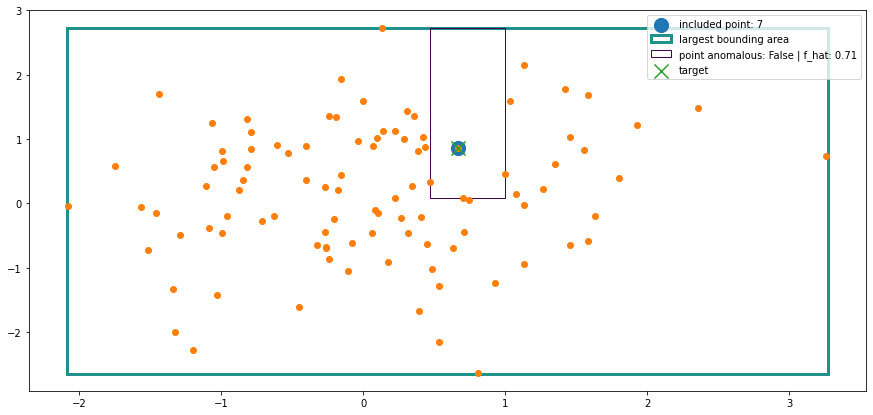

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 8 -------
cutoff (min_area):  63.0
ERROR: Unable to clone Pyomo component attribute. Component
    'MindtPy_utils.objective' contains an uncopyable field '_init_sense'
    (<class 'pyomo.core.base.initializer.ConstantInitializer'>).  Setting
    field to `None` on new object


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.47
         1              MILP         0.0672763            inf      0.0672763      nan%      0.63
*        1         Fixed NLP          0.548325       0.548325      0.0672763    87.73%      0.93
         2              MILP         0.0692895       0.548325      0.0692895    87.36%      1.14
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0875869       0.548325      0.0875869    84.03%      2.06
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP          0.164689       0.548325       0.164689    69.96%      3.40
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.430585       0.548325       0.430585 

evaluating: [-2.07423218 -0.03964674] -> f_hat:0.5483245649150499 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.8237373701375685


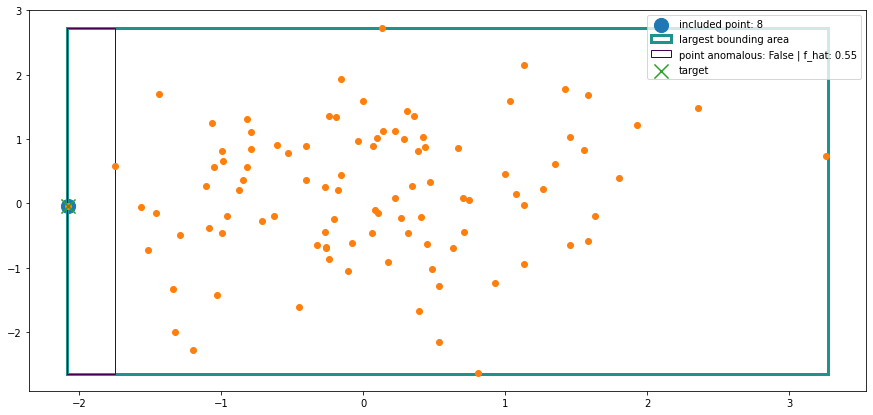

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 9 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.52
         1              MILP         0.0687199            inf      0.0687199      nan%      0.72
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0687847            inf      0.0687847      nan%      1.67
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0766871            inf      0.0766871      nan%      2.61
*        3         Fixed NLP          0.875978       0.875978      0.0766871    91.25%      2.95
         4              MILP         0.0879826       0.875978      0.0879826    89.96%      3.35
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.246568       0.875978       0.246568 

evaluating: [0.9988649  0.45465976] -> f_hat:0.8759783325576554 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.1415807478710458


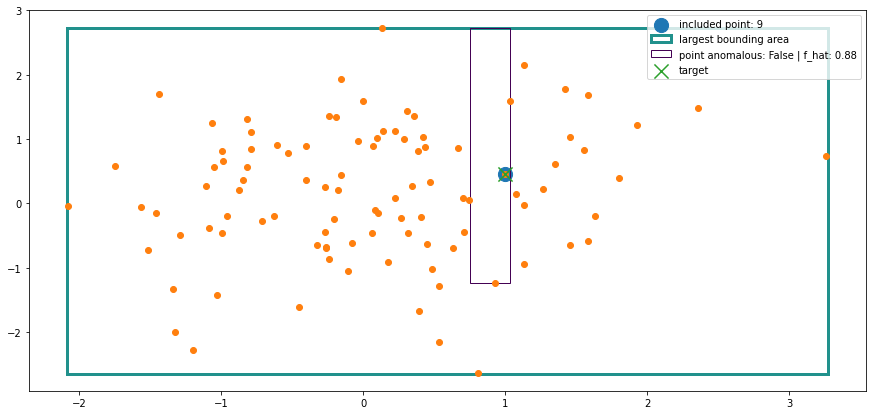

------- itr: 10 -------
cutoff (min_area):  63.0


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.69
         1              MILP         0.0686178            inf      0.0686178      nan%      0.95
NLP subproblem was locally infeasible.
Solving feasibility problem
     

evaluating: [ 1.13544439 -0.93458528] -> f_hat:0.2140181300335123 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  4.672501342962923


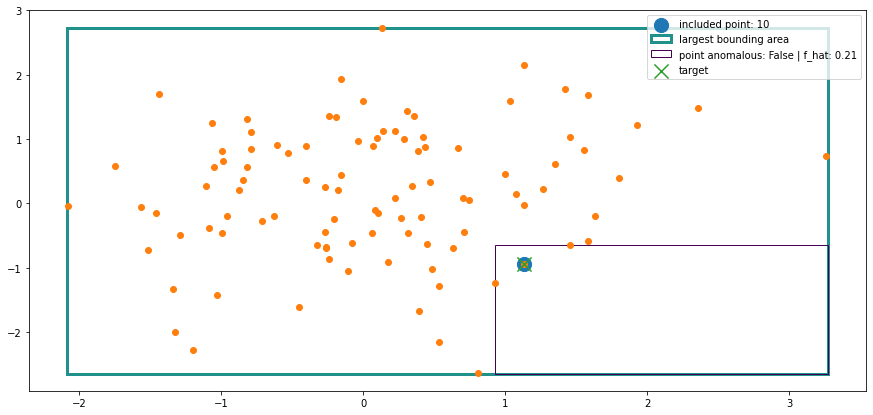

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.


------- itr: 11 -------
cutoff (min_area):  63.0


Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.45
         1              MILP         0.0691904            inf      0.0691904      nan%      0.66
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0692376            inf      0.0692376      nan%      1.58
NLP subproblem was locally infeasible.
Solving feasibility problem
MILP solver reported feasible solution, but not guaranteed to be optimal.
         3              MILP          0.084712            inf      0.0692376      nan%      2.77
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP          0.119004            inf       0.119004      nan%      4.42
NLP subproblem was locally infeasible.
Solving 

evaluating: [0.70655792 0.08285621] -> f_hat:1.4044486681254984 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.4240463502801972


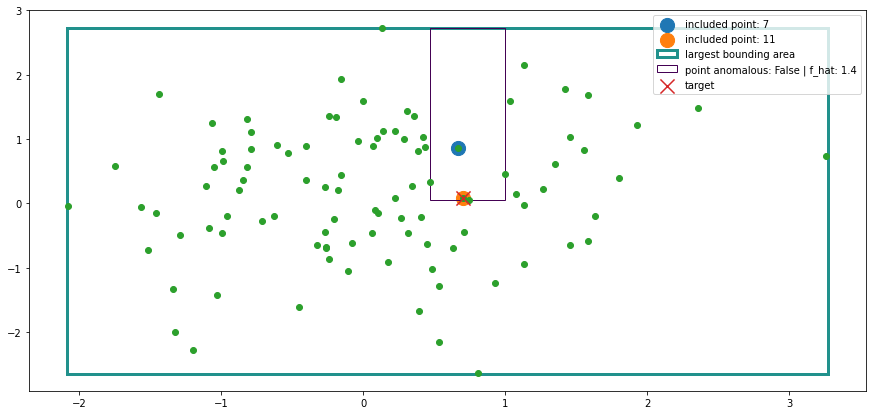

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 12 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.57
         1              MILP         0.0657092            inf      0.0657092      nan%      0.74
*        1         Fixed NLP          0.320266       0.320266      0.0657092    79.48%      1.07
         2              MILP         0.0692668       0.320266      0.0692668    78.37%      1.22
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0918614       0.320266      0.0918614    71.32%      2.09
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP          0.189283       0.320266       0.189283    40.90%      2.98
         4         Fixed NLP          0.746955       0.320266       0.189283    40.90%      3.22
         5              MILP          0.320266 

evaluating: [0.13127173 2.72189547] -> f_hat:0.3202661571484299 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  3.1224029691546265


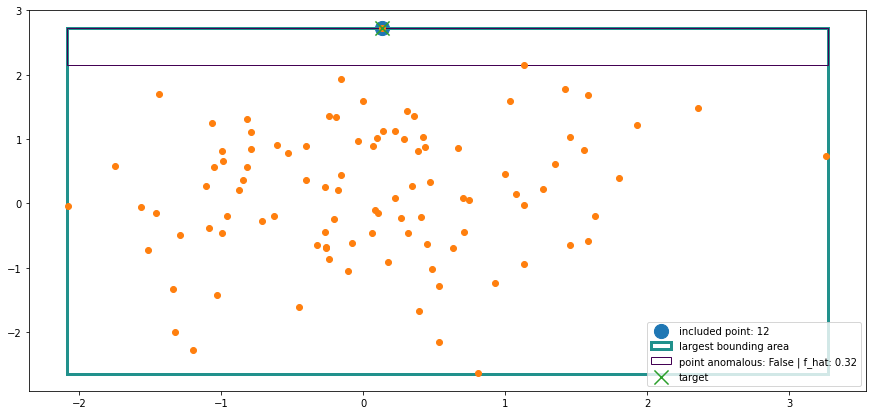

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



------- itr: 13 -------
cutoff (min_area):  63.0


         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.46
         1              MILP         0.0692315            inf      0.0692315      nan%      0.62
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP          0.069247            inf       0.069247      nan%      1.43
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0957754            inf      0.0957754      nan%      2.36
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP          0.120862            inf       0.120862      nan%      4.88
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.141456            inf       0.141456      nan%      8.00
*        5         Fixed NLP           2.64959        2.64959       0.141456    94.66%      8.45
         6              MILP           2.64959       

evaluating: [ 0.10700804 -0.15475777] -> f_hat:2.649588167485912 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.132251433190306


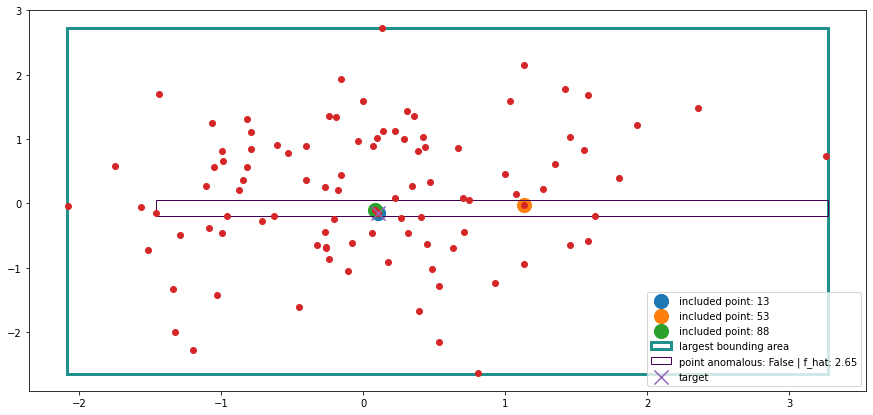

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 14 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.55
         1              MILP         0.0693745            inf      0.0693745      nan%      0.73
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0694219            inf      0.0694219      nan%      1.43
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0892429            inf      0.0892429      nan%      2.17
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP         0.0920212            inf      0.0920212      nan%      3.14
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.642653            inf       0.642653      nan%      4.70
*        5

evaluating: [-0.99213442  0.81734004] -> f_hat:1.1437666741276418 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  2.622912581613832


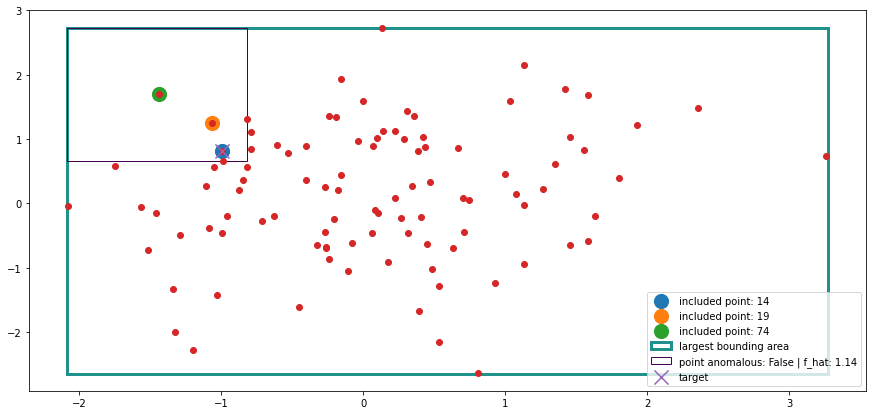

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 15 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.53
         1              MILP         0.0675979            inf      0.0675979      nan%      0.67
*        1         Fixed NLP          0.642142       0.642142      0.0675979    89.47%      0.97
         2              MILP         0.0690146       0.642142      0.0690146    89.25%      1.13
*        2         Fixed NLP          0.232789       0.232789      0.0690146    70.35%      1.46
         3              MILP         0.0691749       0.232789      0.0691749    70.28%      1.58
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP          0.222189       0.232789       0.222189     4.55%      2.48
         4         Fixed NLP          0.258081       0.232789       0.222189     4.55%      2.74
         5       

evaluating: [ 0.53331307 -2.14924621] -> f_hat:0.23278928282013694 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  4.295730404275712


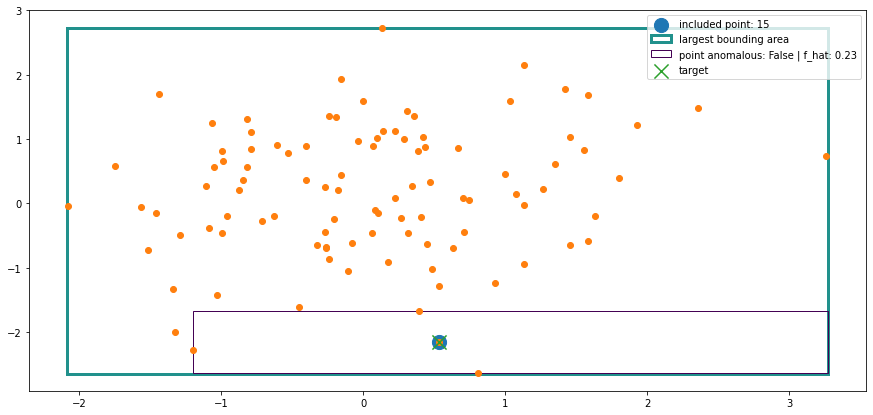

------- itr: 16 -------
cutoff (min_area):  63.0


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.54
         1              MILP         0.0691981            inf      0.0691981      nan%      0.70
NLP subproblem was locally infeasible.
Solving feasibility problem
     

evaluating: [-0.20327614 -0.23779755] -> f_hat:2.701367896504651 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.1105484757858248


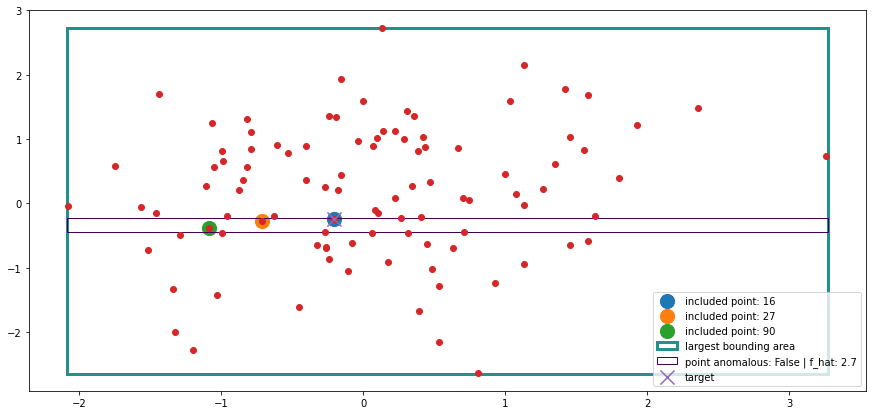

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 17 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



ERROR: Unable to clone Pyomo component attribute. Component
    'pattern_constraint_index' contains an uncopyable field '_init_dimen'
    (<class 'pyomo.core.base.initializer.ConstantInitializer'>).  Setting
    field to `None` on new object


         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.65
         1              MILP         0.0678321            inf      0.0678321      nan%      0.92
*        1         Fixed NLP          0.733559       0.733559      0.0678321    90.75%      1.25
         2              MILP         0.0686821       0.733559      0.0686821    90.64%      1.39
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0828019       0.733559      0.0828019    88.71%      2.36
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP         0.0845365       0.733559      0.0845365    88.48%      3.90
*        4         Fixed NLP          0.629406       0.629406      0.0845365    86.57%      4.23
         5              MILP          0.085945       0.629406       0.085945    86.35%      4.43
*        5         Fixed NLP          0.511243       0.511243       0.085945    83.19%    

evaluating: [-0.44819702 -1.60303153] -> f_hat:0.43900323987783196 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  2.277887516908269


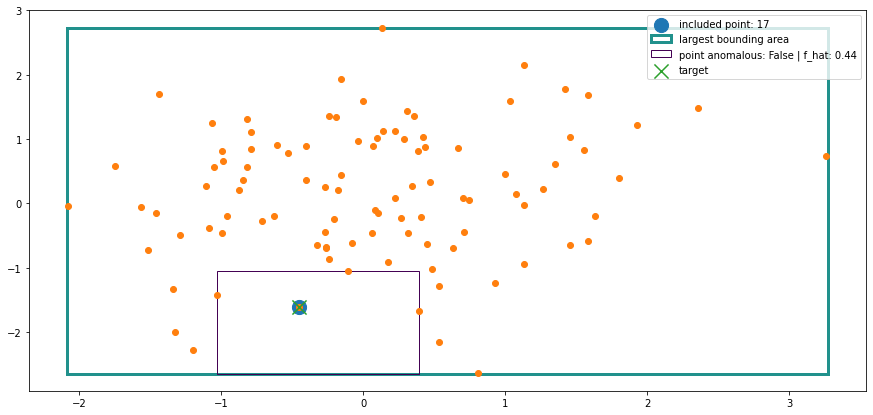

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 18 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.46
         1              MILP         0.0686263            inf      0.0686263      nan%      0.63
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP          0.069244            inf       0.069244      nan%      1.58
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0891742            inf      0.0891742      nan%      2.41
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP           0.09066            inf        0.09066      nan%      3.44
*        4         Fixed NLP          0.949946       0.949946        0.09066    90.46%      3.77
         5              MILP          0.791711       0.949946       0.791711 

evaluating: [-0.32438261 -0.64789069] -> f_hat:0.9499456813757138 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.052691769230213


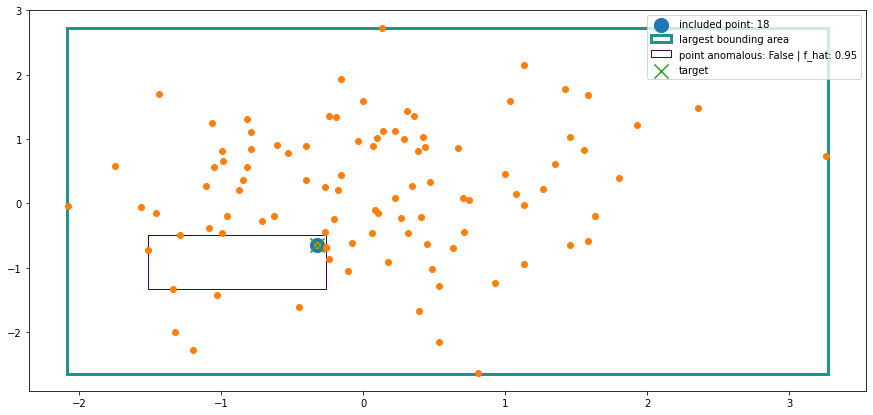

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 19 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.63
         1              MILP          0.068803            inf       0.068803      nan%      0.85
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0692407            inf      0.0692407      nan%      2.12
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0857859            inf      0.0857859      nan%      3.37
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP         0.0898844            inf      0.0898844      nan%      4.53
*        4         Fixed NLP          0.816521       0.816521      0.0898844    88.99%      4.93
         5              MILP          0.665382       0.816521       0.665382 

evaluating: [-1.06289653  1.24806203] -> f_hat:0.8165207960865869 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.2247085497305035


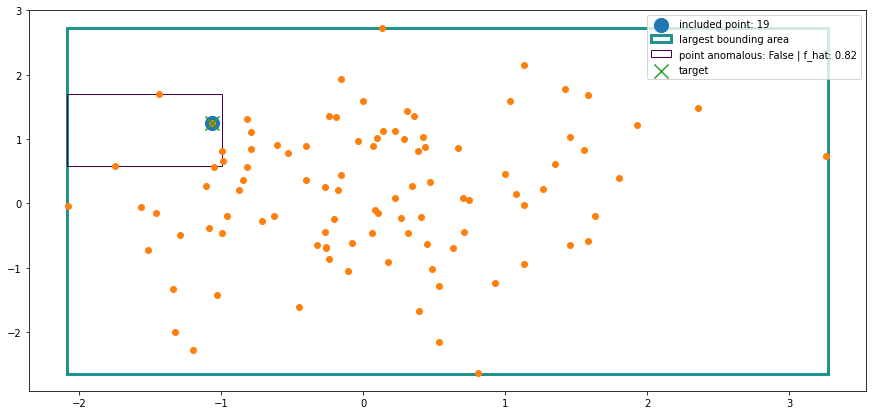

------- itr: 20 -------
cutoff (min_area):  63.0


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.69
         1              MILP         0.0684709            inf      0.0684709      nan%      1.09
NLP subproblem was locally infeasible.
Solving feasibility problem
     

evaluating: [-1.51679213 -0.72516958] -> f_hat:0.5396939097808323 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.8529021392998417


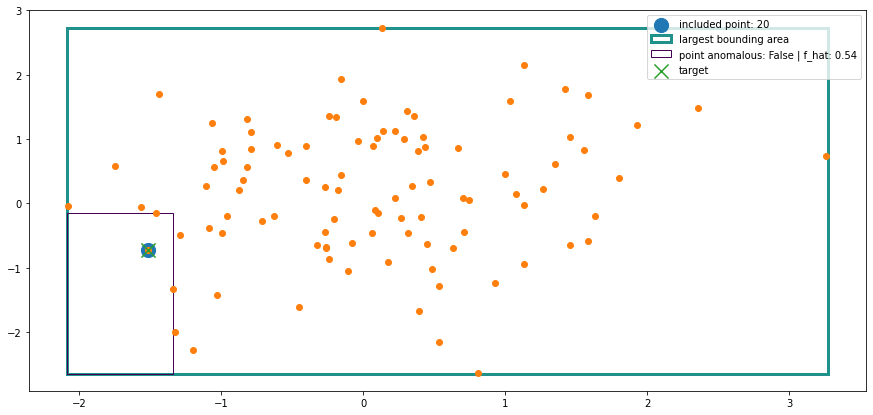

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



------- itr: 21 -------
cutoff (min_area):  63.0


         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.47
         1              MILP         0.0688757            inf      0.0688757      nan%      0.63
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0693086            inf      0.0693086      nan%      1.75
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0868347            inf      0.0868347      nan%      2.90
*        3         Fixed NLP          0.561019       0.561019      0.0868347    84.52%      3.22
         4              MILP          0.561019       0.561019       0.561019    -0.00%      3.74
MindtPy exiting on bound convergence. Absolute gap: -1.4372420031882882e-08 <= absolute tolerance: 0.0001 

 Primal integral          :    0.0000 
 Dual integral            :    1.4230 
 Primal-dual gap integral :    1.4230 


evaluating: [-0.8189518   1.31744063] -> f_hat:0.5610185862080935 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.7824721401103083


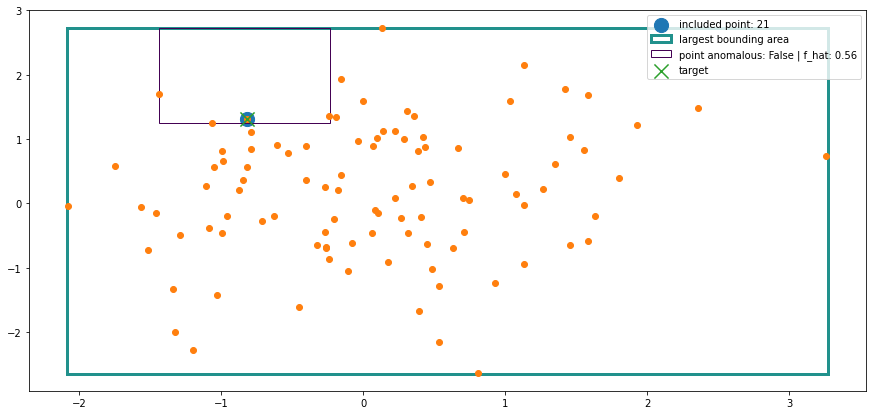

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 22 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.49
         1              MILP         0.0692532            inf      0.0692532      nan%      0.69
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0693296            inf      0.0693296      nan%      1.41
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0868986            inf      0.0868986      nan%      2.30
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP         0.0869221            inf      0.0869221      nan%      3.35
*        4         Fixed NLP           0.56154        0.56154      0.0869221    84.52%      3.60
         5              MILP          0.535286        0.56154       0.535286 

evaluating: [-0.23628849  1.35409812] -> f_hat:0.5615397389835509 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.7808178666217114


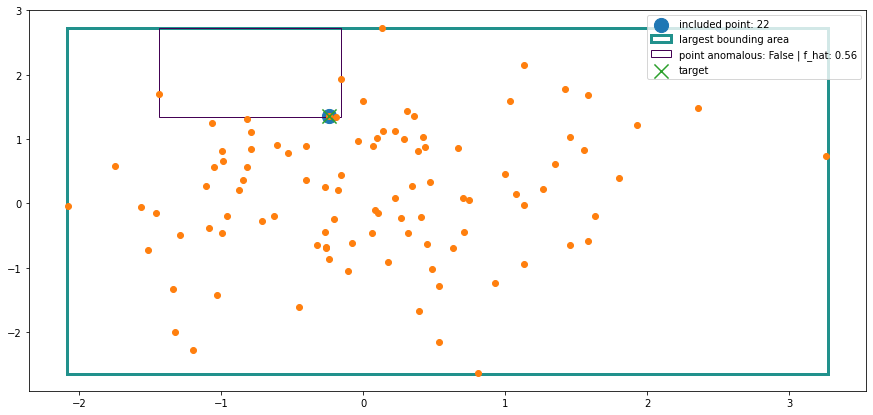

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.


------- itr: 23 -------
cutoff (min_area):  63.0


Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.49
         1              MILP         0.0663829            inf      0.0663829      nan%      0.67
*        1         Fixed NLP          0.389999       0.389999      0.0663829    82.98%      0.98
         2              MILP         0.0691463       0.389999      0.0691463    82.27%      1.13
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0900131       0.389999      0.0900131    76.92%      1.85
         3         Fixed NLP          0.862542       0.389999      0.0900131    76.92%      2.07
         4              MILP          0.105007       0.389999       0.105007    73.08%      2.25
         4         Fixed NLP           1.68874       0.389999

evaluating: [-1.3220718  -1.99253887] -> f_hat:0.389999062053761 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  2.5641087307593353


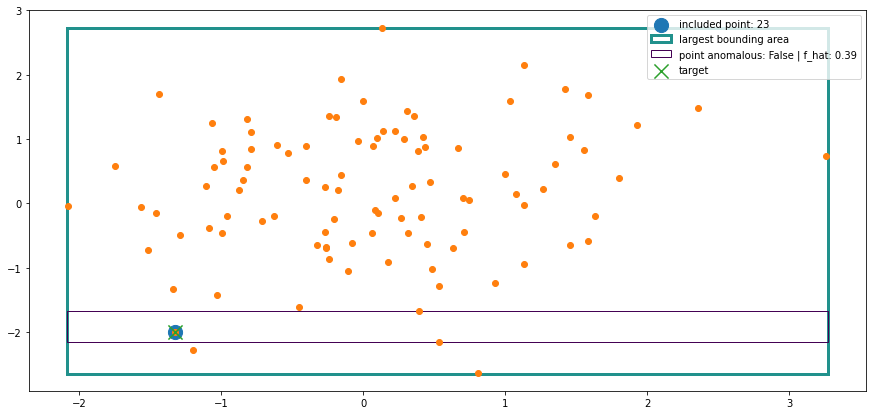

------- itr: 24 -------
cutoff (min_area):  63.0


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.43
         1              MILP         0.0690678            inf      0.0690678      nan%      0.61
NLP subproblem was locally infeasible.
Solving feasibility problem
     

evaluating: [ 0.26584339 -0.23217416] -> f_hat:2.23109018235656 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.3446341271742268


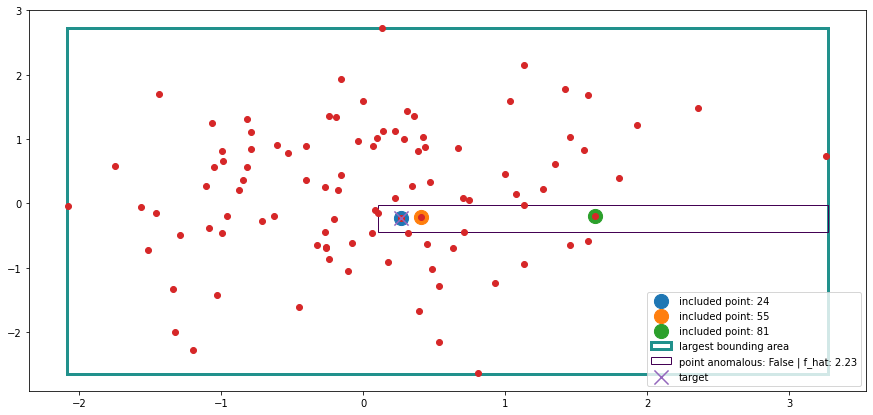

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 25 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.59
         1              MILP         0.0643897            inf      0.0643897      nan%      0.74
*        1         Fixed NLP          0.237202       0.237202      0.0643897    72.85%      1.01
         2              MILP          0.069445       0.237202       0.069445    70.72%      1.17
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0859405       0.237202      0.0859405    63.77%      1.85
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP          0.237202       0.237202       0.237202    -0.00%      3.00
MindtPy exiting on bound convergence. Absolute gap: -4.38292796500761e-09 <= absolute tolerance: 0.0001 

 Primal integral          :    0.0000 

evaluating: [1.13332731 2.14805516] -> f_hat:0.23720179318645637 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  4.215819731235901


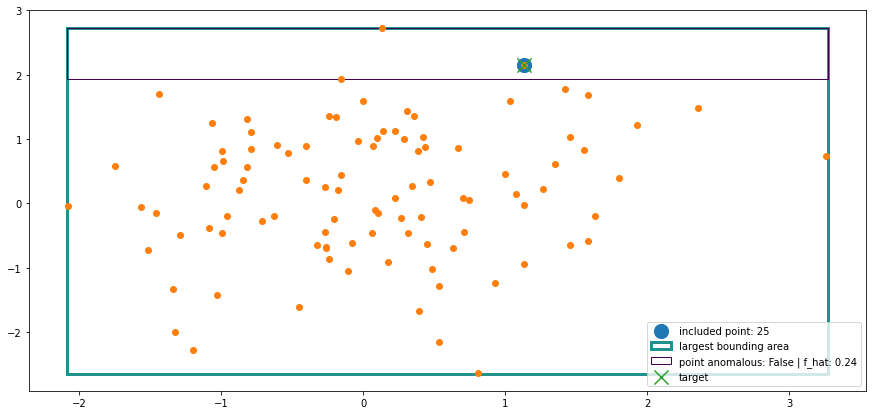

------- itr: 26 -------
cutoff (min_area):  63.0


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.46
         1              MILP         0.0686895            inf      0.0686895      nan%      0.61
NLP subproblem was locally infeasible.
Solving feasibility problem
     

evaluating: [ 1.58060373 -0.58827793] -> f_hat:0.22531348745918645 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  4.438260715223012


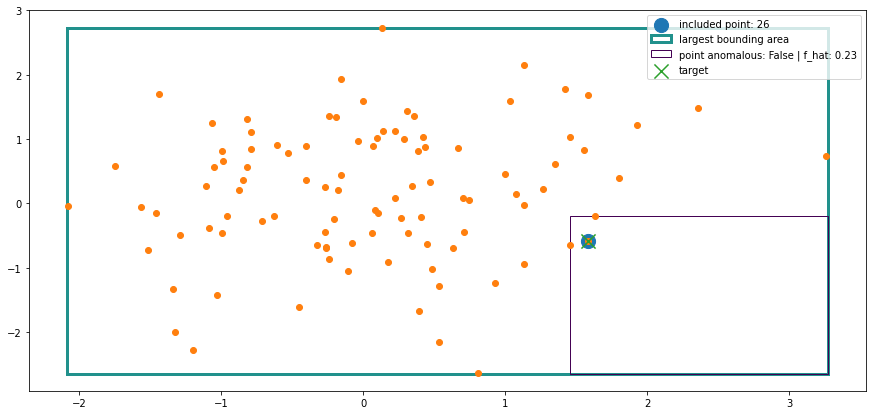

------- itr: 27 -------
cutoff (min_area):  63.0


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.43
         1              MILP         0.0684451            inf      0.0684451      nan%      0.62
NLP subproblem was locally infeasible.
Solving feasibility problem
     

evaluating: [-0.70960983 -0.27025706] -> f_hat:0.748947667137367 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.3352067759583348


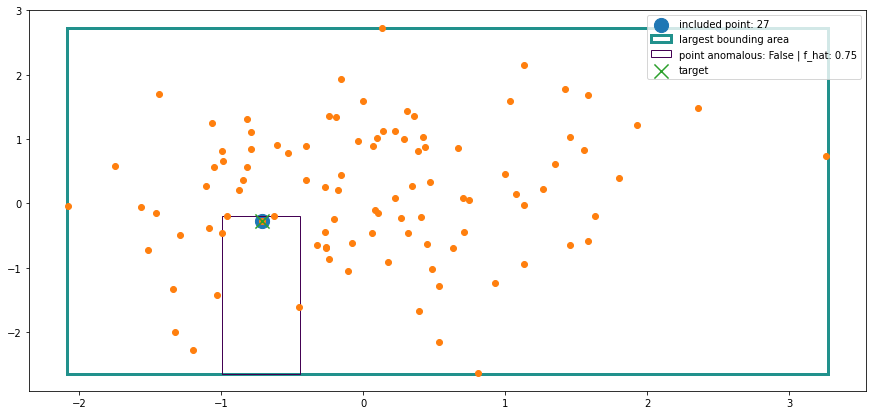

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



------- itr: 28 -------
cutoff (min_area):  63.0


         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.47
         1              MILP         0.0679276            inf      0.0679276      nan%      0.63
*        1         Fixed NLP          0.746116       0.746116      0.0679276    90.90%      0.99
         2              MILP         0.0679306       0.746116      0.0679306    90.90%      1.19
         2         Fixed NLP          0.780293       0.746116      0.0679306    90.90%      1.47
         3              MILP         0.0754865       0.746116      0.0754865    89.88%      1.68
*        3         Fixed NLP          0.215177       0.215177      0.0754865    64.92%      1.98
         4              MILP          0.215177       0.215177       0.215177     0.00%      2.19
MindtPy exiting on bound convergence. Absolute gap: 1.35523758881817e-10 <= absolute tolerance: 0.0001 

 Primal integral          :    0.7737 
 Dual integral            :    0.2590 
 Primal-dual gap integral :    1.0327 


evaluating: [ 0.92970864 -1.23883456] -> f_hat:0.21517745322769471 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  4.6473270549485886


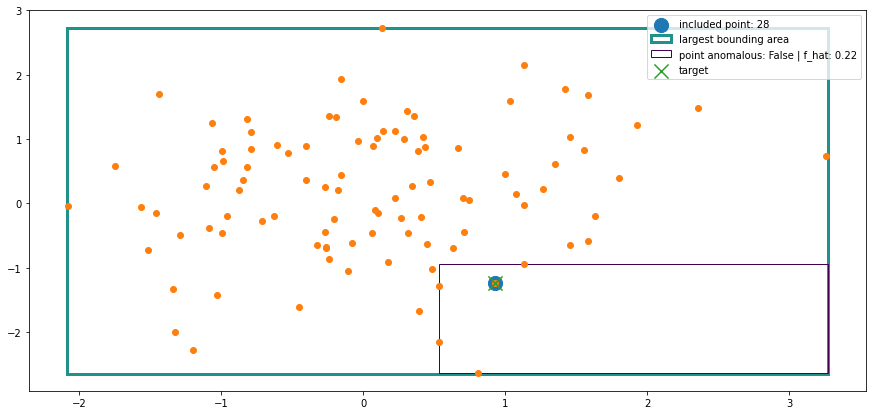

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 29 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.52
         1              MILP         0.0691344            inf      0.0691344      nan%      0.68
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP          0.069264            inf       0.069264      nan%      1.58
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0914494            inf      0.0914494      nan%      2.98
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP          0.116586            inf       0.116586      nan%      4.08
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.288547            inf       0.288547      nan%      8.59
*        5

evaluating: [-0.84393311  0.36260764] -> f_hat:2.2076476668021825 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.3589124954642577


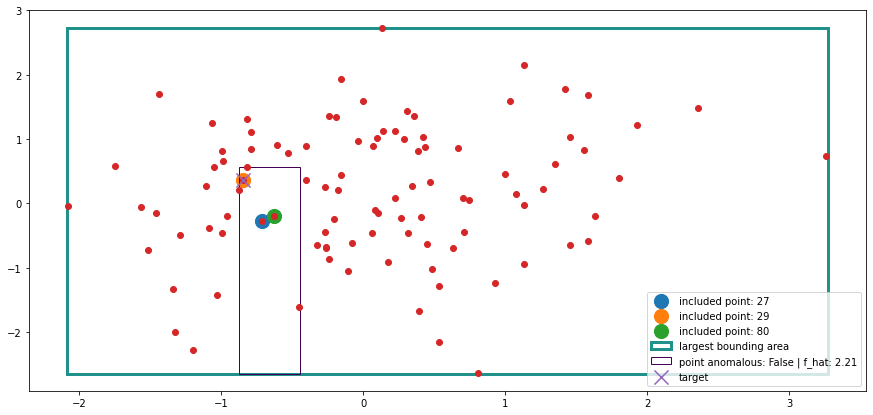

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



------- itr: 30 -------
cutoff (min_area):  63.0


         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.49
         1              MILP         0.0687273            inf      0.0687273      nan%      0.69
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0693697            inf      0.0693697      nan%      1.52
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0810584            inf      0.0810584      nan%      2.49
*        3         Fixed NLP          0.872258       0.872258      0.0810584    90.71%      2.81
         4              MILP         0.0924736       0.872258      0.0924736    89.40%      3.16
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.468808       0.872258       0.468808    46.25%      4.23
*        5         Fixed NLP          0.838952       0.838952       0.468808    44.12%      4.54
         6             

evaluating: [-1.10439429  0.2732206 ] -> f_hat:0.8389519096689252 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.191963434941854


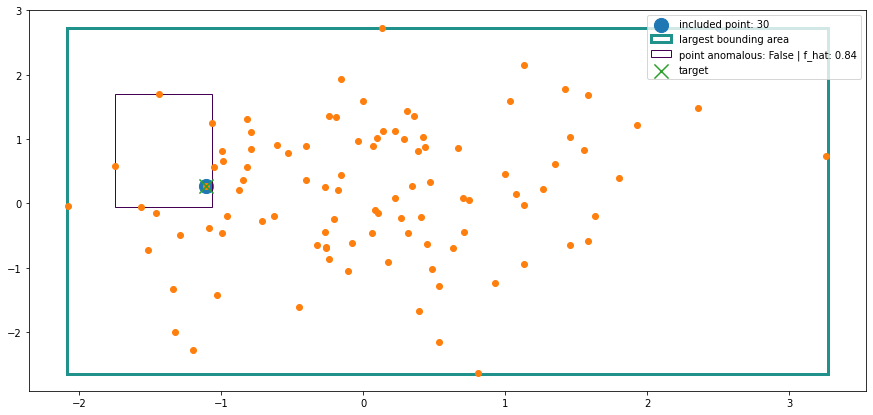

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 31 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.64
         1              MILP         0.0689545            inf      0.0689545      nan%      0.88
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0692856            inf      0.0692856      nan%      1.84
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0868393            inf      0.0868393      nan%      2.63
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP          0.124277            inf       0.124277      nan%      4.03
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP           1.50294            inf        1.50294      nan%      6.50
*        5

evaluating: [-0.40194717  0.36473647] -> f_hat:1.921369669880795 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.0409241029208518


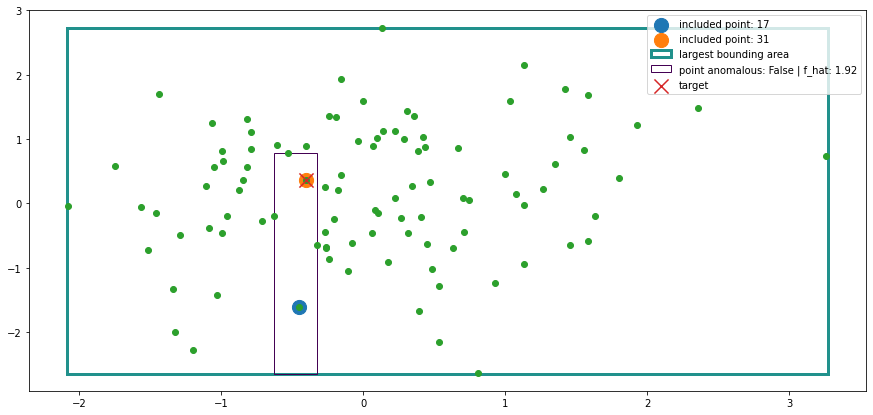

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



------- itr: 32 -------
cutoff (min_area):  63.0


         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.50
         1              MILP         0.0692153            inf      0.0692153      nan%      0.70
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0692292            inf      0.0692292      nan%      1.44
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0872104            inf      0.0872104      nan%      2.39
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP         0.0974283            inf      0.0974283      nan%      3.53
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.115846            inf       0.115846      nan%      5.09
*        5         Fixed NLP           1.75041        1.75041       0.115846    93.38%      5.40
         6              MILP           1.73349       

evaluating: [ 0.31964554 -0.46556473] -> f_hat:1.7415662921105433 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.1483915421768236


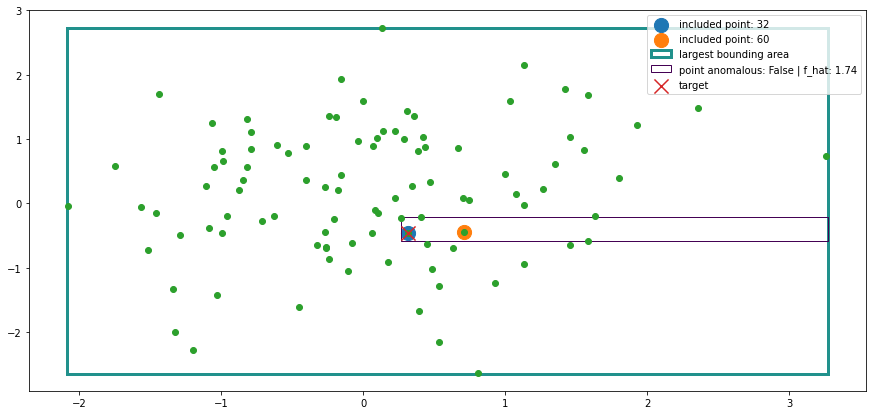

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.


------- itr: 33 -------
cutoff (min_area):  63.0


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.53
         1              MILP         0.0688112            inf      0.0688112      nan%      0.74
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP         0.0690267            inf      0.0690267      nan%      1.58
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0835472            inf      0.0835472      nan%      2.44
*        3         Fixed NLP          0.998303       0.998303      0.0835472    91.63%      2.77
         4              MILP          0.092099       0.998303       0.092099    90.77%      3.24
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.669247       0.998303       0.669247 

evaluating: [1.45684563 1.03712271] -> f_hat:0.920045718433559 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.086902509260701


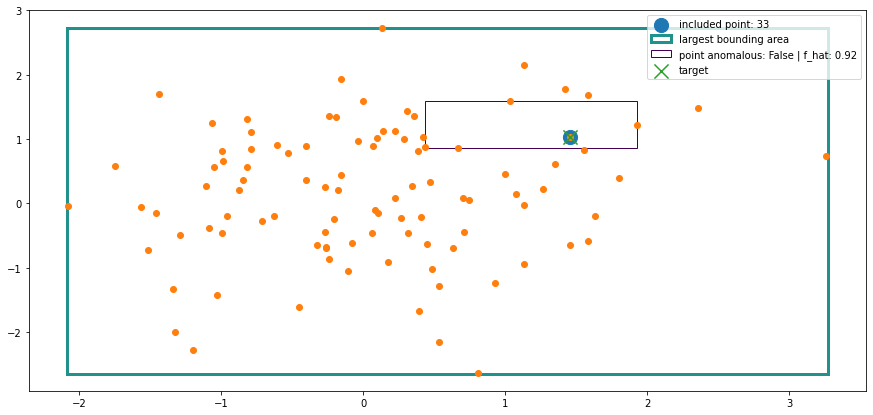

------- itr: 34 -------
cutoff (min_area):  63.0


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.43
         1              MILP         0.0688653            inf      0.0688653      nan%      0.60
NLP subproblem was locally infeasible.
Solving feasibility problem
     

evaluating: [0.13945512 1.12849252] -> f_hat:1.804649656953243 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.6623725211378955


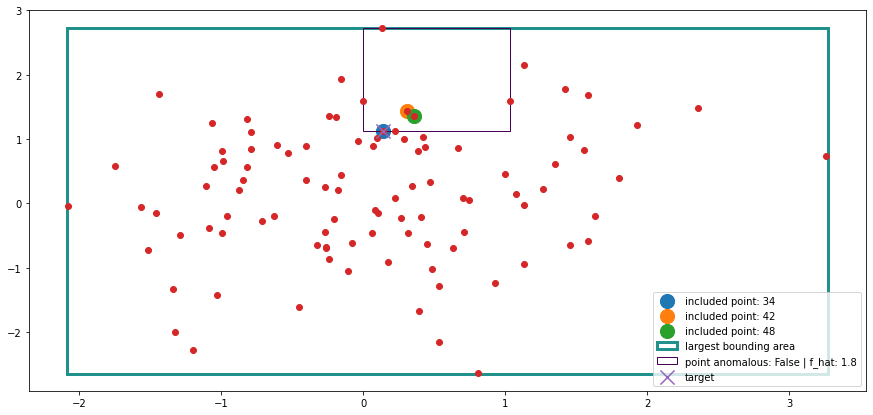

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.


------- itr: 35 -------
cutoff (min_area):  63.0


Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.60
         1              MILP         0.0663594            inf      0.0663594      nan%      0.76
*        1         Fixed NLP          0.387055       0.387055      0.0663594    82.86%      1.05
         2              MILP         0.0682764       0.387055      0.0682764    82.36%      1.19
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP          0.113786       0.387055       0.113786    70.60%      1.88
         3         Fixed NLP          0.933112       0.387055       0.113786    70.60%      2.10
         4              MILP          0.202745       0.387055       0.202745    47.62%      2.40
         4         Fixed NLP          0.559806       0.387055

evaluating: [-1.19856995 -2.28322829] -> f_hat:0.387055289494265 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  2.5836102157565697


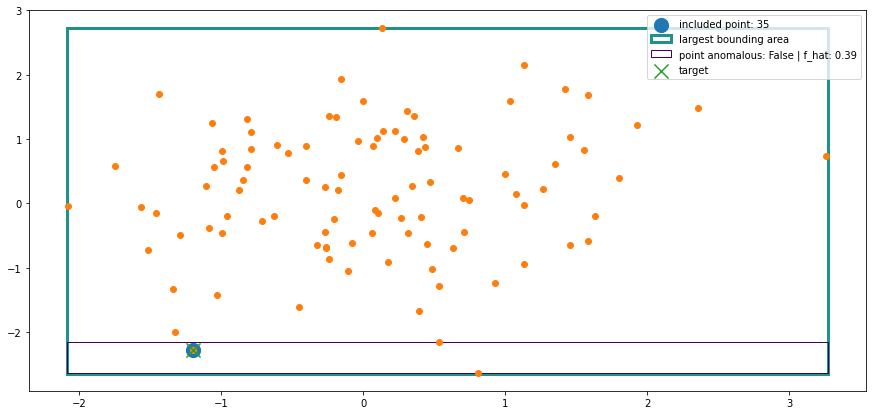

------- itr: 36 -------
cutoff (min_area):  63.0


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.54
         1              MILP         0.0670373            inf      0.0670373      nan%      0.71
*        1         Fixed NLP          0.494593       0.494593      0.067

evaluating: [-0.15701033  1.93495357] -> f_hat:0.30311346773238257 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  3.299094584879663


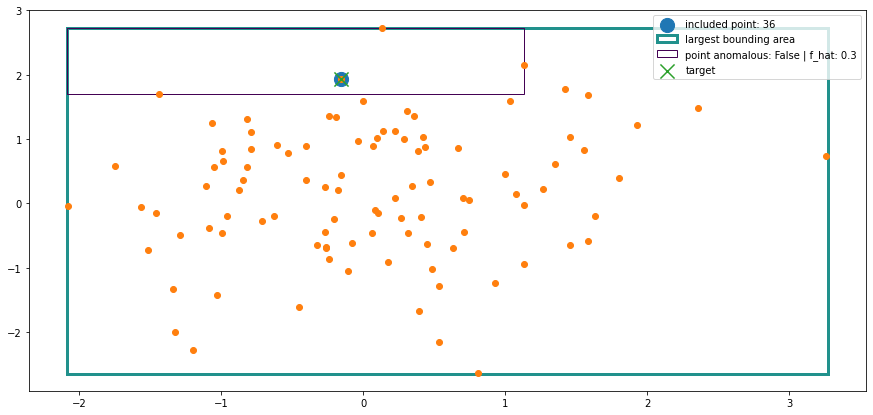

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



------- itr: 37 -------
cutoff (min_area):  63.0


         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.44
         1              MILP         0.0692984            inf      0.0692984      nan%      0.68
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP          0.069368            inf       0.069368      nan%      1.64
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP         0.0869743            inf      0.0869743      nan%      2.47
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP         0.0950665            inf      0.0950665      nan%      3.39
NLP subproblem was locally infeasible.
Solving feasibility problem
         5              MILP          0.114998            inf       0.114998      nan%      4.87
NLP subproblem was locally infeasible.
Solving feasibility problem
         6              MILP           1.55526            inf        1.55526      n

evaluating: [-0.81793132  0.56538033] -> f_hat:1.448218137759653 <?> mu:0.1
Classification result:  False
area_calculated_pattern:  1.3810074241259929


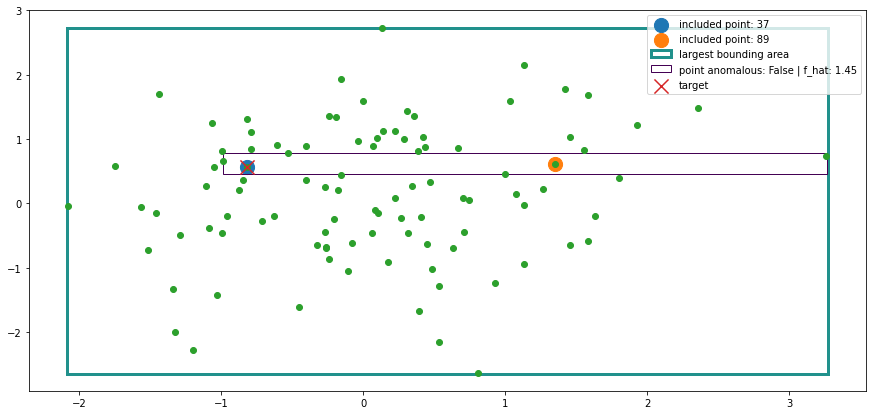

------- itr: 38 -------
cutoff (min_area):  63.0


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 912 constraints (1 nonlinear) and 0 disjunctions, with 506 variables, of which 500 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP         0.0347387            inf      0.0347387      nan%      0.46
         1              MILP         0.0692846            inf      0.0692846      nan%      0.66
NLP subproblem was locally infeasible.
Solving feasibility problem
     

In [4]:
points_outside_of_largest_bounding_area = 0
indeces = []
predictions = []

mu, epsilon, delta = 0.1, 0.1, 0.1
N, d = training_set.shape
v = 2 * d 
min_area = 63.0 # MIN_AREA 
print("min_area: ", min_area)
print(f"N={N} , d={d}, vc={v}")

lba = np.zeros((d,2), dtype=float)
for i in np.arange(0,d,1):
    lba[i] = np.array(
        [
            np.min(training_set[:, i]) - 1e-2, 
            np.max(training_set[:, i]) + 1e-2
        ]
    )

for i, point_to_be_classified in enumerate(training_set): # testing_set
    print(f"------- itr: {i} -------")
    
    minlp_model, classification_result = minlp_has_rare_pattern(
        point_to_be_classified,
        training_set,
        PatternSpace(
            type = PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
            cutoff = min_area if min_area != None else 0.1
        ),
        mu,
        debugging_minlp_model=True,
    )
    
    print("Classification result: ",classification_result)
    predictions.append(classification_result)
    
    ax = plt.gca()
    if minlp_model is not None:
        result = (
            mu,
            classification_result,
            minlp_model
        )
        included_points = minlp_model.extract_points_included_in_pattern()
        calculated_pattern = minlp_model.extract_pattern()
        area_calculated_pattern = np.prod(np.apply_along_axis(lambda i: i[1] - i[0], axis=1, arr=calculated_pattern))
        print("area_calculated_pattern: ", area_calculated_pattern)
        # assert area_calculated_pattern is not None, "area of minimized pattern is None"
        # assert area_calculated_pattern >= 0, "area of minimized pattern is negative"
        largest_bounding_area = minlp_model.largest_bounding_area
        [plt.scatter(
            x=p[0], 
            y=p[1], 
            marker="o", 
            s=200, 
            label=f"included point: {np.argwhere(training_set == p)[0,0]}") for _, p in enumerate(included_points)
        ]
        plt.legend([f"area of calculated pattern: {area_calculated_pattern}"])
        draw_largest_bounding_area(largest_bounding_area, ax)
        draw2dpattern(calculated_pattern, ax, classification_result, minlp_model.minimized_f_hats, len(training_set))
        plt.legend(bbox_to_anchor=(1.1, 1.1))
    else:
        print(f"---> !! minlp model is none and classification results: {classification_result} !! ")
        draw_largest_bounding_area(lba, ax)
        ax.legend()
        points_outside_of_largest_bounding_area += 1 
        indeces.append(i)

    plt.scatter(x=training_set[:,0], y=training_set[:,1])
    plt.scatter(
        x=point_to_be_classified[0], 
        y=point_to_be_classified[1], 
        marker="x",  
        s=200, 
        label="target") 
    plt.legend()
    plt.show()

print("-- END __")
print("Points that lie outside of the largest bounding area defined by the training set: ",points_outside_of_largest_bounding_area) 
print("indices of the points: ", indeces)

# Testing RarePatternDetect class

In [ ]:
# # print(training_set)

# rpd = RarePatternDetect(
#     delta=0.01,
#     tau=0.01,
#     epsilon=0.01,
#     pattern_space = PatternSpace(
#         PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
#         cutoff = 0.41 # 3 #min_area
#     )
# )
# rpd.load_training_data(training_set)
# preds = [rpd.is_anomalous(point_to_be_classified) for _, point_to_be_classified in enumerate(testing_set)]
# print(preds)

# print(predictions)
# # -> should get the same results
# assert preds == predictions
# # ssert preds in np.array([True, False]) and no "None"
# assert None not in preds 
# assert None not in predictions

# Experiment: Prediction using Isolation Forest and comparison with the minlp solver

In [ ]:
# from sklearn.ensemble import IsolationForest

# clf = IsolationForest(random_state=0).fit(X)
# r = clf.predict(X) # -1 anomalie
# r = np.where(r==1, r, False).astype(bool)
# # print("r: ",r)

# count_similar_predictions = np.count_nonzero(r == preds)
# per_similar_predictions = count_similar_predictions/len(X)
# count_similar_predictions,  per_similar_predictions


# Testing the solver on more than two features

In [ ]:
# with np.load('../ADbench-main/datasets/Classical/6_cardio.npz') as data:
#     X = data['X']
#     y = data['y']

# TRAINING_LIMIT = 200
# TESTING_LIMIT = 10
# FEATURES = 2

# X = X[:,:FEATURES]

# training_set = X[:TRAINING_LIMIT]
# training_labels = y[:TRAINING_LIMIT]

# # slicing
# testing_set = X[TRAINING_LIMIT:-1:300]
# testing_labels = y[TRAINING_LIMIT:-1:300]

# rpd = RarePatternDetect(
#     delta=0.1,
#     tau=0.1,
#     epsilon=0.1,
#     pattern_space = PatternSpace(
#         PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
#         cutoff = 0.1
#     )
# )

# # print("testing_set: ", testing_set)
# rpd.fit(training_set)

# preds = [rpd.predict_score(point_to_be_classified) for _, point_to_be_classified in enumerate(testing_set)]

# print("--- RESULTS ---")
# print("predictions: ", preds)

# Evaluating the performance (AUROC) on 300 points with 3 features

In [ ]:
# # Loading the data
# with np.load('../ADBench-main/datasets/Classical/6_cardio.npz') as data:
#     X = data['X']
#     y = data['y']
#     idx = np.random.permutation(len(X))
#     X,y = X[idx], y[idx]

# TRAINING_LIMIT = 300
# FEATURES = 3
# X = X[:TRAINING_LIMIT,:FEATURES]
# y = y[:TRAINING_LIMIT]

In [ ]:
# # creating a range of taus
# taus = [0.1] # np.linspace(start=0.1,stop=1.0,num=5)

# # Creating a range of min areas
# # min_areas = np.linspace(start=0.1,stop=40.0,num=4)

# predictions_list = []
# print(f"num datapoints: {len(y)}")

# # for i, ma in enumerate(min_areas):
#     # print(f"––– ––– ––– new round: i={i}, min_area:{ma}  ––– ––– –––")
# for i, tau in enumerate(taus):
#     print(f"––– ––– ––– new round: i={i}, tau:{tau}  ––– ––– –––")
#     rpd = RarePatternDetect(
#         delta=0.1,
#         tau=tau,
#         epsilon=0.1,
#         pattern_space = PatternSpace(
#             PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
#             cutoff = 30.0914 # 63.0 for 100 points # 48.8 for 200
#         )
#     )

#     rpd.fit(X)
#     preds = []
#     for _, point_to_be_classified in enumerate(X):
#         preds.append(rpd.predict_score(point_to_be_classified))

#     print(f" --> RESULTS for tau: {tau} ---")
#     # print(f" --> RESULTS for min_area: {ma} ---")
#     # print("predictions: ", preds)
#     # print("labels: ", y)
#     # print("r: ",r)
#     predictions_list.append(preds)
#     preds = np.where(preds==1, preds, False).astype(bool)
#     count_similar_predictions = np.count_nonzero(y == preds)
#     per_similar_predictions = count_similar_predictions/len(y)
#     print(f" similar results: {count_similar_predictions},  percentage: {per_similar_predictions}")

In [ ]:
# from sklearn import metrics
# print(p)
# for _, p in enumerate(predictions_list):
#     auc = metrics.roc_auc_score(y, p)

#     # Recall that a model with an AUC score of 0.5 is no better than a model that performs random guessing.
#     print("auroc: ",auc)

#     fpr, tpr, _ = metrics.roc_curve(y, p)
    
#     #create ROC curve
#     plt.plot(fpr,tpr)
#     print(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

# Evaluating the performance on 100 points with two features and scaling tau 

In [ ]:
# # Loading the data
# with np.load('../ADBench-main/datasets/Classical/6_cardio.npz') as data:
#     X = data['X']
#     y = data['y']
#     idx = np.random.permutation(len(X))
#     X,y = X[idx], y[idx]

# TRAINING_LIMIT = 100
# FEATURES = 2
# X = X[:TRAINING_LIMIT,:FEATURES]
# y = y[:TRAINING_LIMIT]

# # creating a range of taus
# taus = np.linspace(start=0.1,stop=1.0,num=5)

# # Creating a range of min areas
# # min_areas = np.linspace(start=0.1,stop=40.0,num=4)

# predictions_list = []
# print(f"num datapoints: {len(y)}")

# # for i, ma in enumerate(min_areas):
#     # print(f"––– ––– ––– new round: i={i}, min_area:{ma}  ––– ––– –––")
# for i, tau in enumerate(taus):
#     print(f"––– ––– ––– new round: i={i}, tau:{tau}  ––– ––– –––")
#     rpd = RarePatternDetect(
#         delta=0.1,
#         tau=tau,
#         epsilon=0.1,
#         pattern_space = PatternSpace(
#             PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
#             cutoff = 30.0914 # 63.0 for 100 points # 48.8 for 200
#         )
#     )

#     rpd.fit(X)
#     preds = []
#     for _, point_to_be_classified in enumerate(X):
#         preds.append(rpd.predict_score(point_to_be_classified))

#     print(f" --> RESULTS for tau: {tau} ---")
#     predictions_list.append(preds)
#     preds = np.where(preds==1, preds, False).astype(bool)
#     count_similar_predictions = np.count_nonzero(y == preds)
#     per_similar_predictions = count_similar_predictions/len(y)
#     print(f" similar results: {count_similar_predictions},  percentage: {per_similar_predictions}")

In [ ]:
# for i, (p,tau) in enumerate(zip(predictions_list,taus)):
#     # TODO: make sure this is correct 
#     auc = metrics.roc_auc_score(y, p)

#     # Recall that a model with an AUC score of 0.5 is no better than a model that performs random guessing.
#     print("auroc: ",auc)

#     fpr, tpr, _ = metrics.roc_curve(y, p)
    
#     #create ROC curve
#     plt.scatter(fpr,tpr, label=f"{tau}")
#     plt.legend(loc="upper left")
#     print(fpr,tpr)

# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()